# ライブラリ

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
# 表示オプションの設定
pd.set_option('display.max_columns', None)  # 列の数の制限をなくす
pd.set_option('display.width', 1000)        # 表示幅を広げる

# データ読み込み

In [3]:
train = pd.read_csv('../data/train.csv', index_col=None)
test = pd.read_csv('../data/test.csv', index_col=None)

- データの確認

In [4]:
# トレーニングデータの最初の5行を表示
print("Training Data - First 5 Rows:")
print(train.head())

# トレーニングデータの基本情報
print("\nTraining Data - Info:")
print(train.info())

# テストデータの基本情報
print("\nTest Data - Info:")
print(test.info())

# トレーニングデータの基本統計量
print("\nTraining Data - Describe:")
print(train.describe())

Training Data - First 5 Rows:
   gameId  blueFirstBlood  blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  blueTotalGold  blueTotalExperience  blueWins
0       0               0          5           8            6                  0            0          14536                17256         0
1       1               1         10           1            5                  0            0          14536                17863         0
2       2               0          3          10            2                  0            0          17409                17256         0
3       3               1          7          10            8                  0            0          19558                18201         0
4       4               0          4           9            4                  0            0          17409                17256         0

Training Data - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 10 columns):


# 各特徴量の説明

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


- 用意されている特徴量リスト

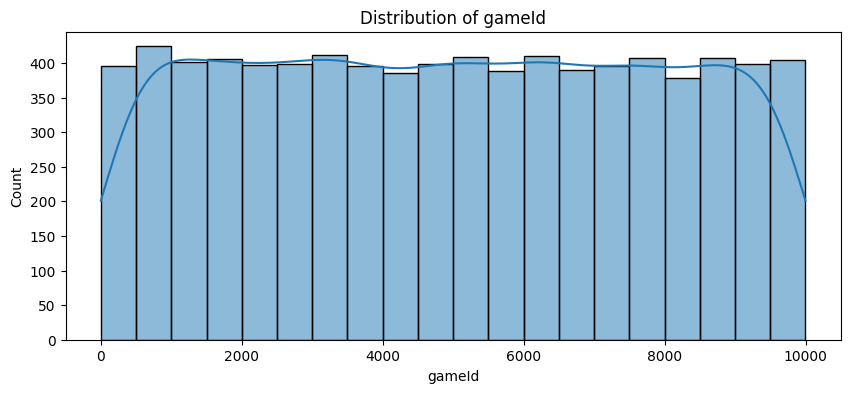

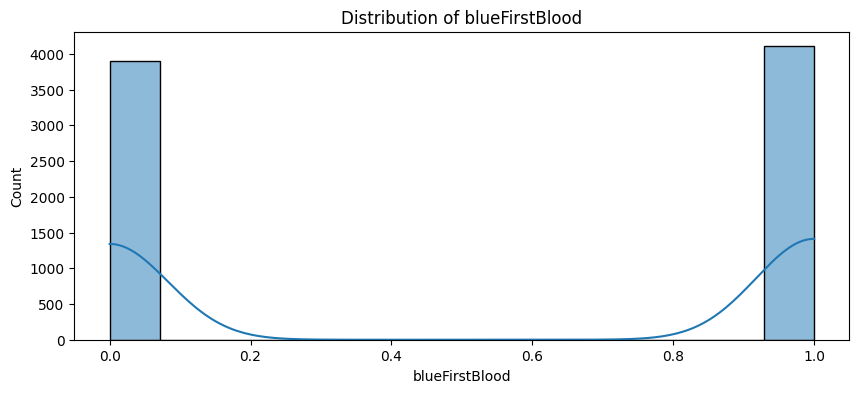

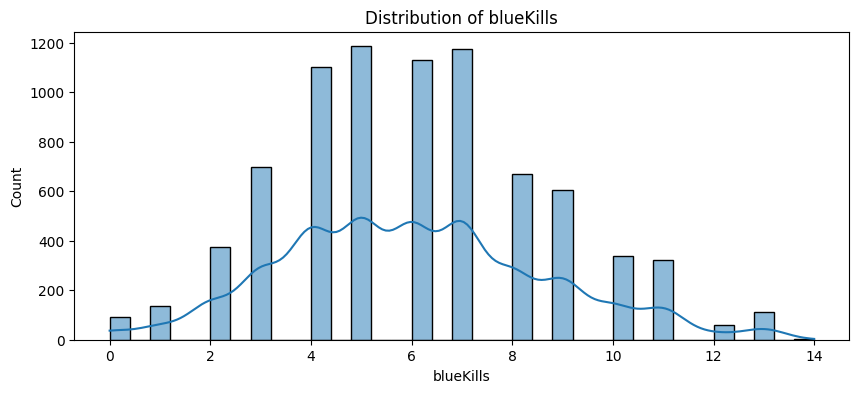

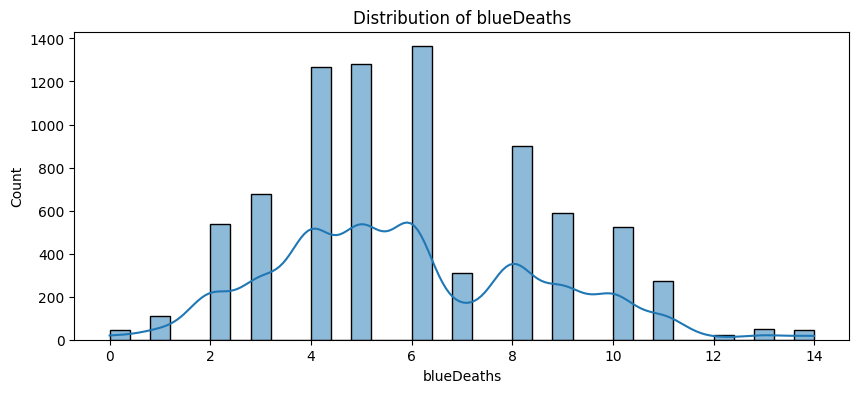

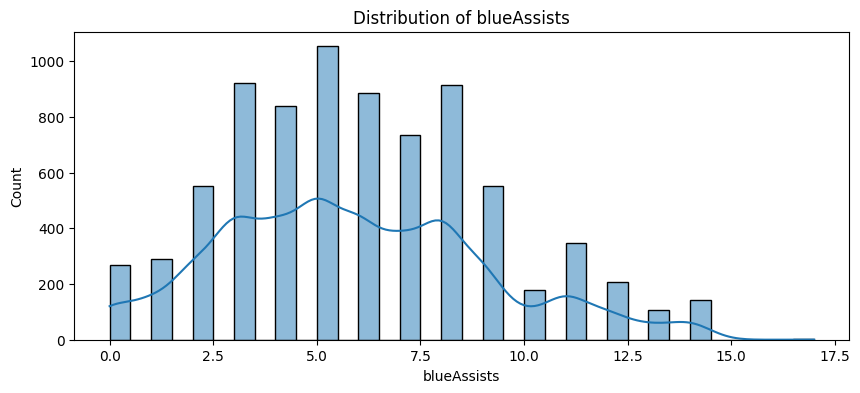

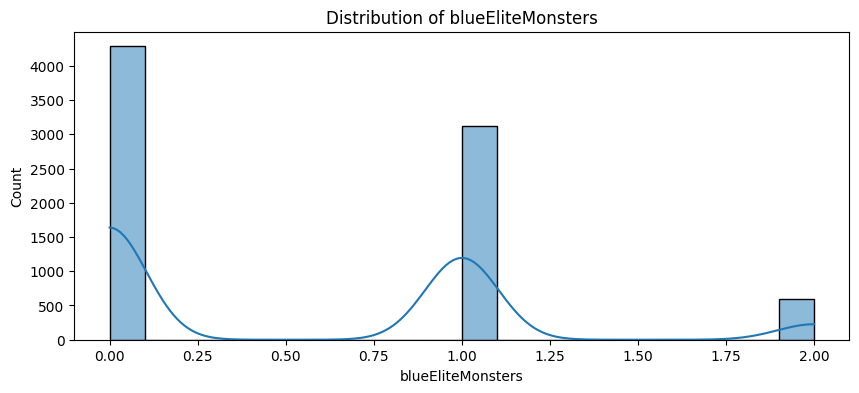

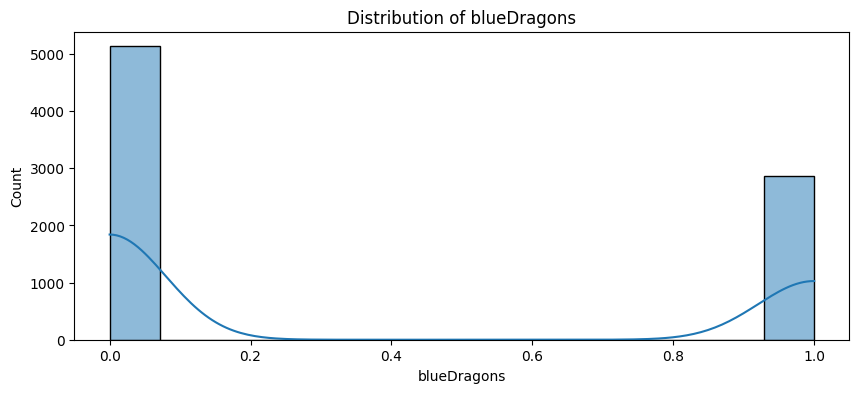

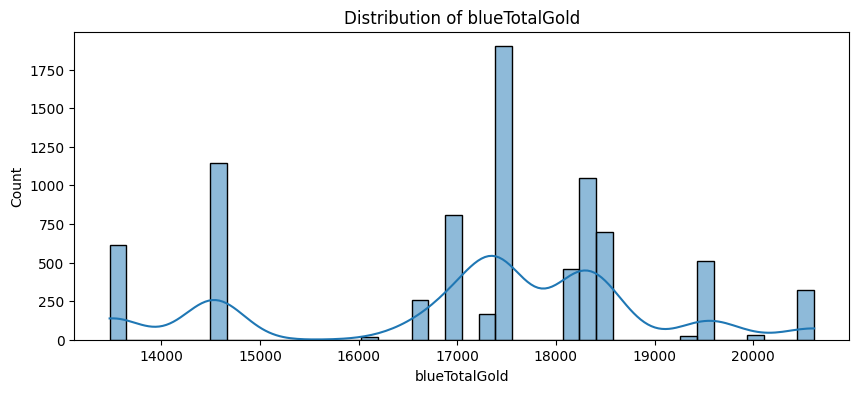

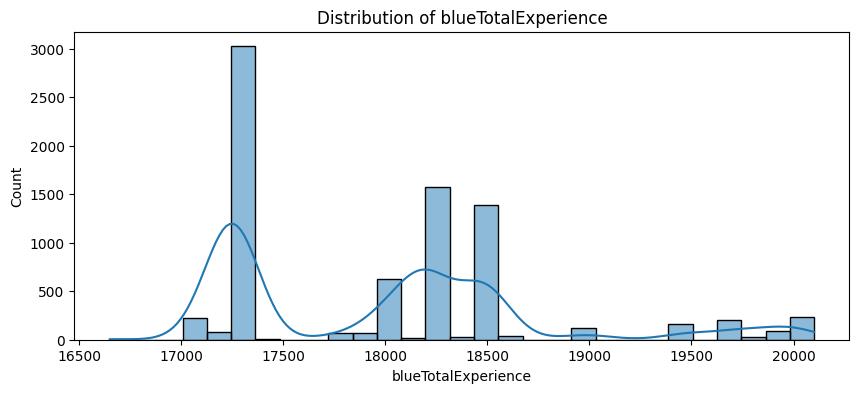

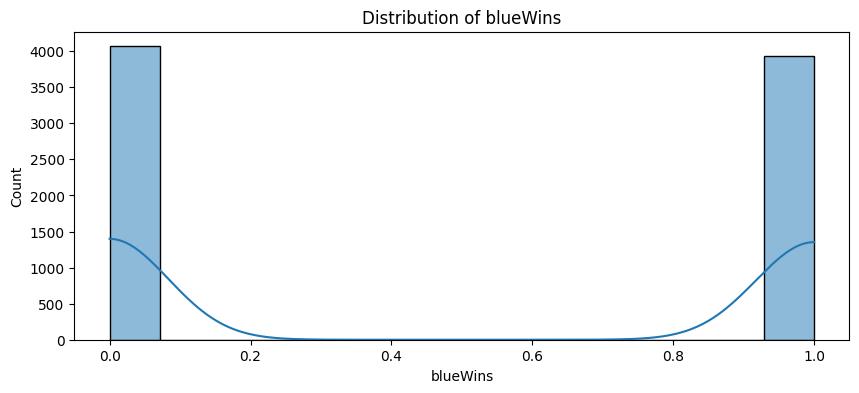

In [5]:
# 各特徴量の分布を観察（数値データの場合）
for column in train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(train[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

- 各特長量の相関

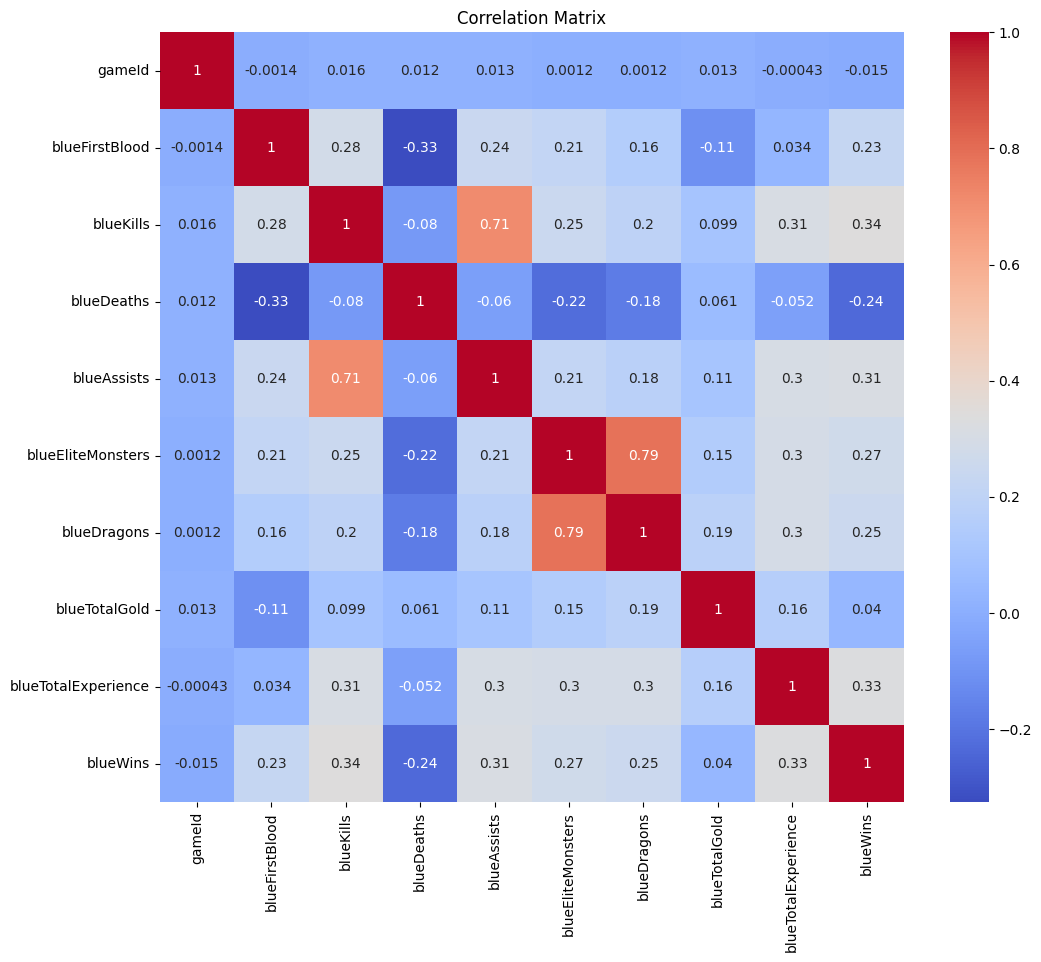

In [6]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- targetとの相関を確認

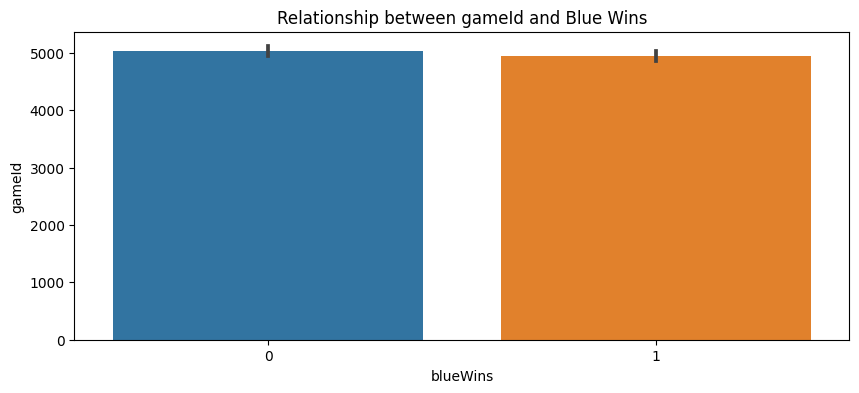

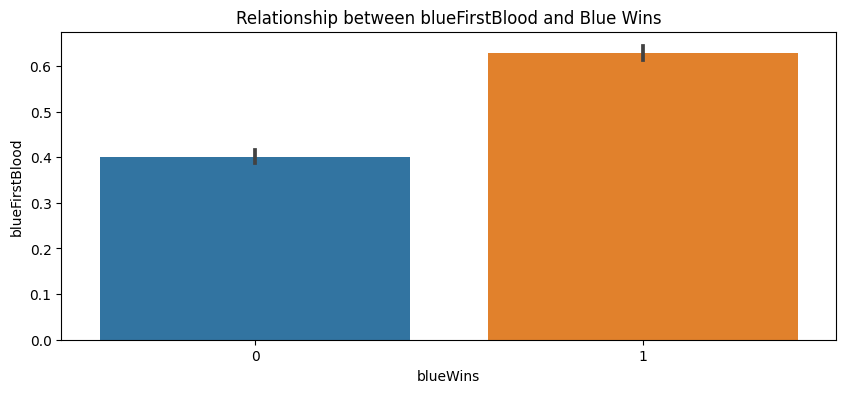

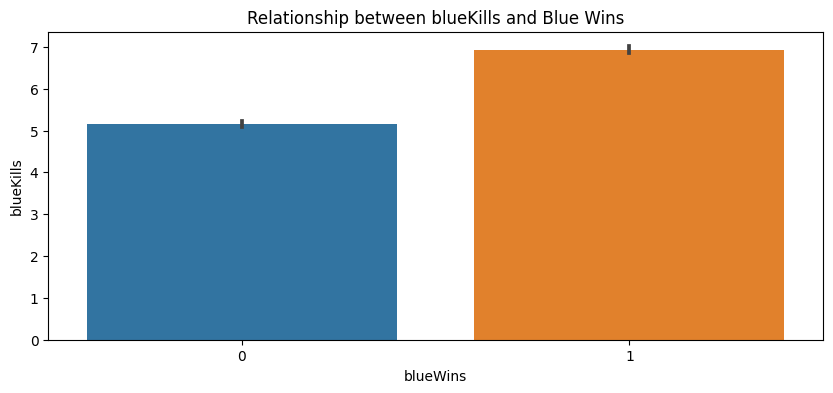

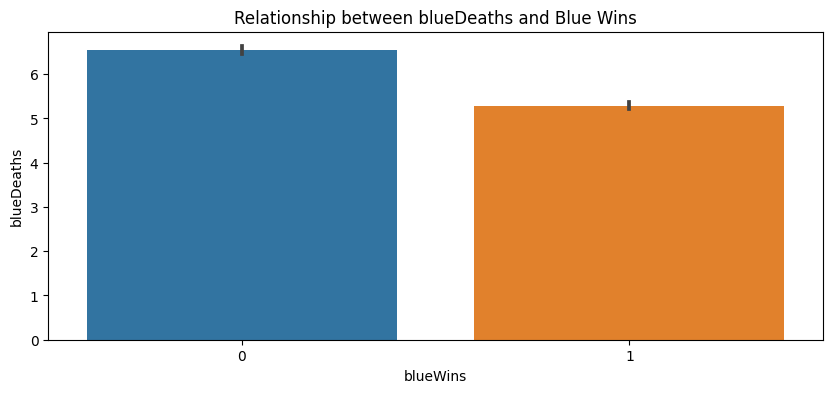

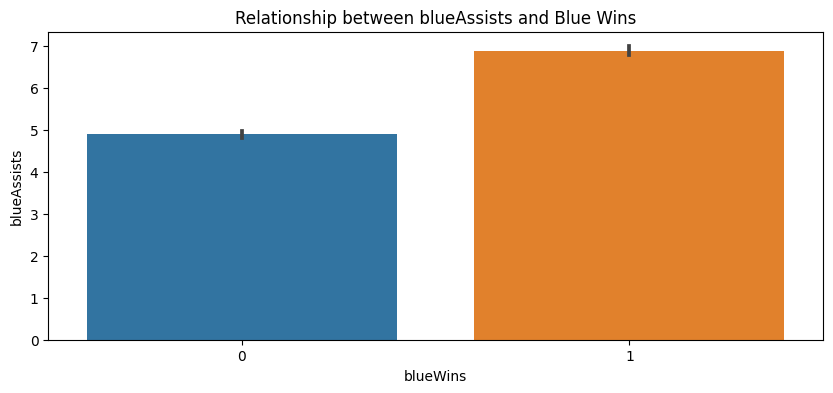

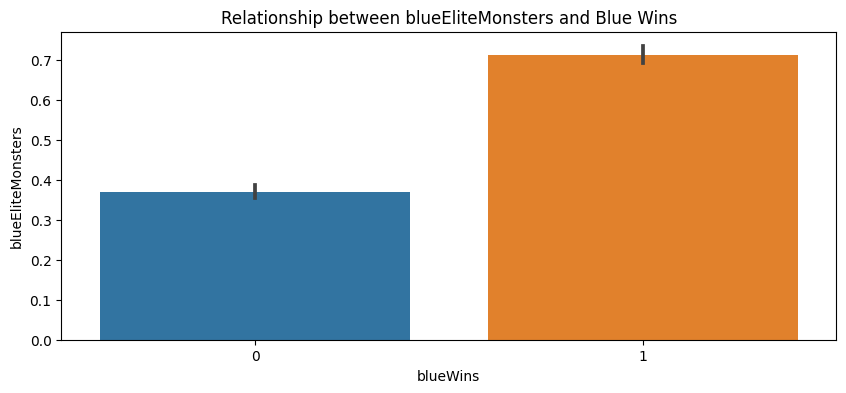

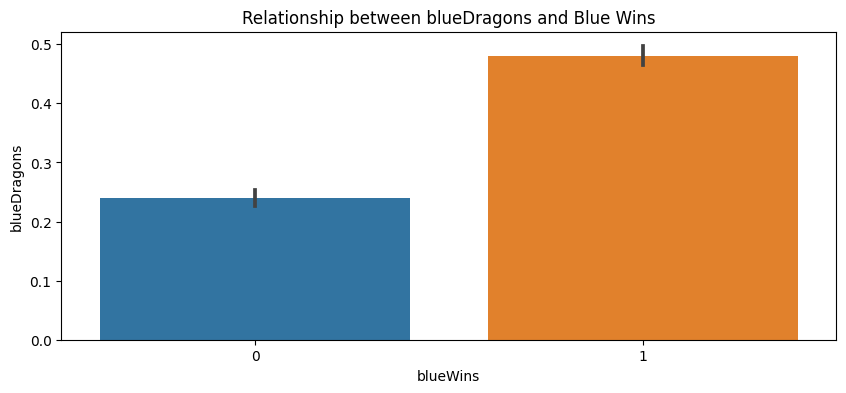

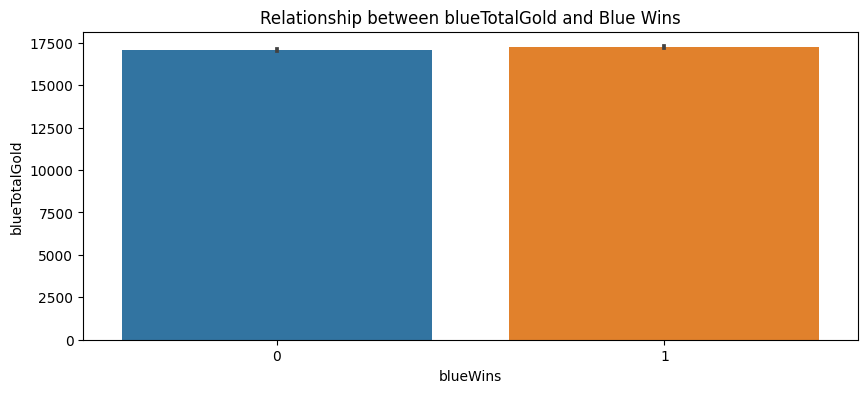

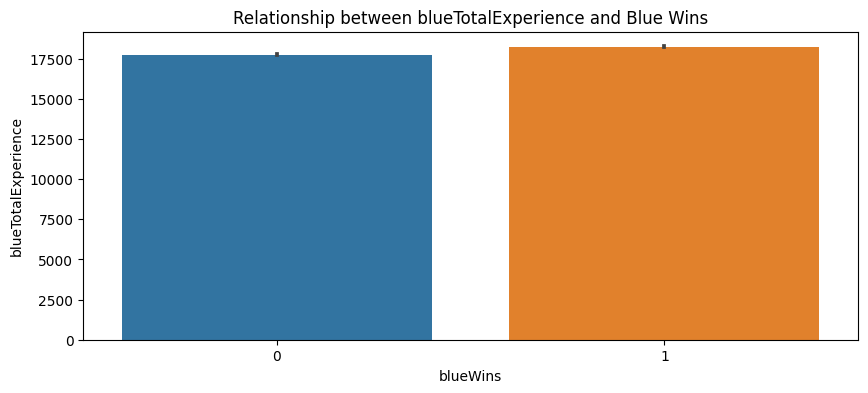

In [7]:
# ターゲット変数との関係を観察
for column in train.columns:
    if column != 'blueWins':
        plt.figure(figsize=(10, 4))
        sns.barplot(x='blueWins', y=column, data=train)
        plt.title(f'Relationship between {column} and Blue Wins')
        plt.show()

- 重複確認

In [8]:
# 全体的な重複の確認
duplicates = train.duplicated()
if duplicates.any():
    print(f"全体的な重複が {duplicates.sum()} 行見つかりました。")
else:
    print("全体的な重複はありません。")

# 特定の列（例：gameId）における重複の確認
duplicates_in_gameId = train.duplicated(subset=['gameId'])
if duplicates_in_gameId.any():
    print(f"gameId 列における重複が {duplicates_in_gameId.sum()} 行見つかりました。")
else:
    print("gameId 列における重複はありません。")

全体的な重複はありません。
gameId 列における重複はありません。


- 欠損確認

In [9]:
# 全体的な重複の確認
drops = train.dropna()
if duplicates.any():
    print(f"全体的な欠損が {drops.sum()} 行見つかりました。")
else:
    print("全体的な欠損はありません。")


全体的な欠損はありません。


# 特長量エンジニアリング

- 一旦作成

In [10]:
# 新しい特徴量の作成
# キルとデスの比率
train['killDeathRatio'] = train['blueKills'] / (train['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

# アシストの割合
train['assistRate'] = train['blueAssists'] / (train['blueKills'] + 1)

# エリートモンスターとドラゴンの比率
train['eliteMonsterDragonRatio'] = train['blueEliteMonsters'] / (train['blueDragons'] + 1)

# 既存の特徴量の変換
# ゴールドと経験値の対数変換
train['logTotalGold'] = np.log1p(train['blueTotalGold'])
train['logTotalExperience'] = np.log1p(train['blueTotalExperience'])

# 相互作用特徴量
# ゴールドと経験値の相互作用
train['goldXexperience'] = train['blueTotalGold'] * train['blueTotalExperience']

# ヘラルドの討伐数
train['blueHerald'] = train['blueEliteMonsters'] - train['blueDragons']

# エリートモンスターとヘラルドの比率
train['eliteMonsterHeraldRatio'] = train['blueEliteMonsters'] / (train['blueHerald'] + 1)